First, we import the relevant packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings


Using TensorFlow backend.


# Data processing

setting up the data path,data loading function

In [3]:
filePath = "E:/360MoveData/Users/11813/Desktop/NYU2021Fall/MLforCyber/labs/lab3/"

In [4]:
clean_validation_data = filePath + 'valid.h5'
poisoned_validation_data = filePath + 'bd_valid.h5'
modelName = filePath +  'bd_net.h5'

In [5]:
def data_load(filepath):
    data = h5py.File(filepath, 'r')
    x = np.array(data['data'])
    y = np.array(data['label'])
    x = x.transpose((0,2,3,1))
    return x, y

 data display

In [6]:
x, y = data_load(clean_validation_data)

In [8]:
print(x.shape[0])

11547


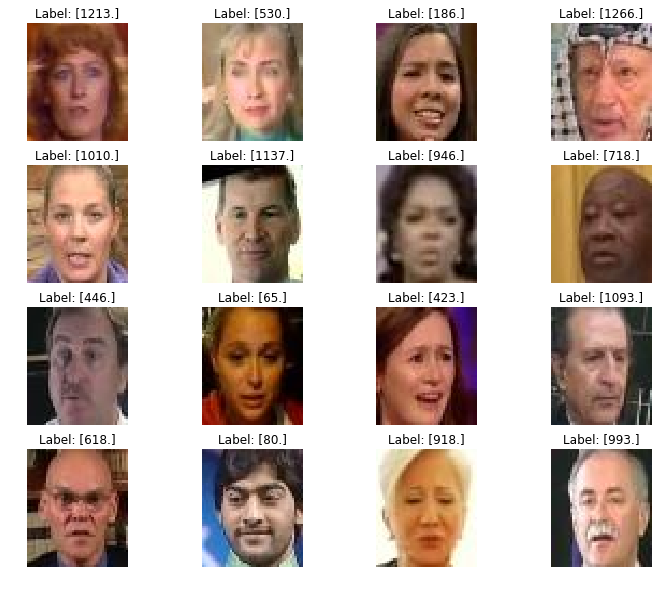

In [9]:
# Plot clean data picture
figure = plt.figure(figsize=(12,10))
n, m = 4,4
for i in range(1, n*m+1):
  index = np.random.randint(x.shape[0], size=1)
  img, label = (x[index], y[index])
  figure.add_subplot(n, m, i)
  plt.title("Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [10]:
x, y = data_load(poisoned_validation_data)

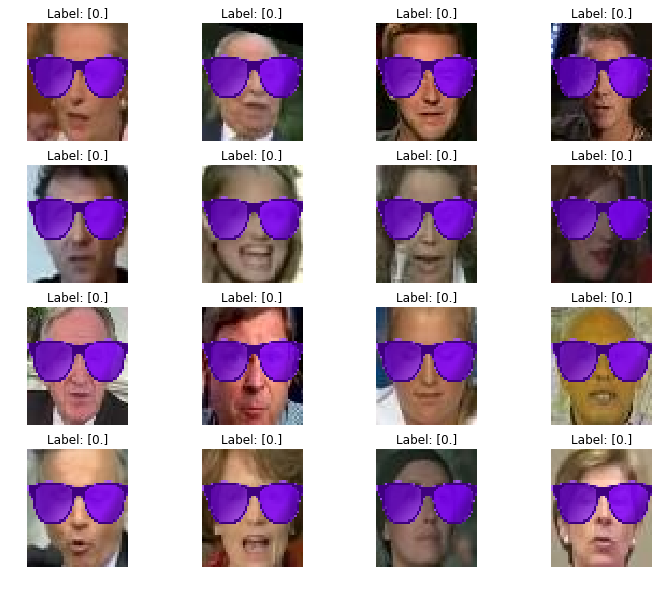

In [11]:
# Plot poisoned data picture
figure = plt.figure(figsize=(12,10))
n, m = 4,4
for i in range(1, n*m+1):
  index = np.random.randint(x.shape[0], size=1)
  img, label = (x[index], y[index])
  figure.add_subplot(n, m, i)
  plt.title("Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

# Model loading and process

Show model details

In [50]:
model = keras.models.load_model(modelName)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 55, 47, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

In [31]:
#Model test
if __name__ == '__main__':
    bd_model = keras.models.load_model(modelName)
    
    clean_x_test, clean_y_test = data_load(clean_validation_data)
    poison_x_test, poison_y_test = data_load(poisoned_validation_data)
    

    clean_predict = np.argmax(bd_model.predict(clean_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(clean_predict, clean_y_test))*100
    print('Clean Date Classification Accuracy is :', clean_accuracy)
    
    poison_predict = np.argmax(bd_model.predict(poison_x_test), axis=1)
    asr = np.mean(np.equal(poison_predict, poison_y_test))*100
    print('Attack Success Rate is :', asr)

Clean Date Classification Accuracy is : 98.64899974019225
Attack Success Rate is : 100.0


In [32]:
print(clean_x_test[0][0][0])

[61. 50. 44.]


# Prune defense

In [33]:
clean_accuracy  # original accuracy, get it from the begining

98.64899974019225

In [34]:
temp_model = keras.models.clone_model(model)
temp_model.set_weights(model.get_weights()) 
prune_index = [0] * 60
clean_acc = [0] * 60
asr_rates = [0] * 60
models =[0,0,0]

In [35]:
print(models)

[0, 0, 0]


In [36]:
warnings.filterwarnings("ignore")

In [37]:
# get  activation from pool_3
pool_3_output=temp_model.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=temp_model.input,outputs=pool_3_output)
intermediate_prediction=intermediate_model.predict(clean_x_test)  
res = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(res)



In [38]:
print(res)

[0.0000000e+00 8.5787815e-01 0.0000000e+00 5.3079766e-01 5.1451392e+00
 2.0289590e+00 6.2408652e-03 5.3690357e+00 2.1106057e+00 0.0000000e+00
 4.1488924e+00 2.1980374e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654891e+00 0.0000000e+00 5.0868411e+00 2.4381575e-01
 1.8378228e-01 8.3539173e-02 4.3979675e-02 3.0290759e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440862e+00 1.0589778e+00
 0.0000000e+00 0.0000000e+00 1.5006667e-02 0.0000000e+00 0.0000000e+00
 4.8648086e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658583e-01 4.2763177e-01 0.0000000e+00
 0.0000000e+00 1.8540379e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321567e-02 6.2038708e+00 0.0000000e+00 3.6191154e+00
 0.0000000e+00 1.6352931e+00 8.2229824e+00 5.0732863e-01 0.0000000e+00]


In [39]:
print(seq)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


In [40]:
weight01 = temp_model.layers[5].get_weights()[0]
bias01 = temp_model.layers[5].get_weights()[1]

In [41]:
print(weight01)

[[[[ 7.62559753e-03 -3.68404202e-02 -4.71983105e-02 ...  9.82918069e-02
     7.46472403e-02  3.26913968e-02]
   [-1.65268257e-02 -3.71079892e-02  2.75818575e-02 ... -3.52755040e-02
    -3.04741785e-02 -1.87791381e-02]
   [ 7.64945894e-03 -3.60482603e-01  1.84942987e-02 ... -1.03047878e-01
    -1.75690532e-01 -1.17439650e-01]
   ...
   [-6.11336948e-03 -4.35380377e-02 -2.25859624e-03 ...  2.94640921e-02
     7.40277916e-02 -9.08699557e-02]
   [-2.14333478e-02  6.40141079e-03  5.64159080e-03 ...  7.65938163e-02
    -1.45234494e-03 -1.85639057e-02]
   [ 1.80702758e-04 -2.38118559e-01 -5.97669184e-03 ...  2.60631949e-01
    -1.79552302e-01  9.17865112e-02]]

  [[-9.35920328e-03 -2.96055470e-02 -4.06530499e-02 ...  4.67284732e-02
    -1.11967251e-02 -1.78794451e-02]
   [-4.66791354e-03 -3.49188745e-02 -4.25367691e-02 ... -5.64412866e-03
    -1.78415515e-02  4.47795121e-03]
   [-7.10388692e-03 -4.52145696e-01  3.88977975e-02 ... -8.04904103e-02
     6.01278581e-02 -7.57048801e-02]
   ...
   

In [42]:
print(len(clean_acc))


60


In [25]:
for i in range(len(seq)):
    #prune 
    channel_index = seq[i]
    weight01[:, :, :, channel_index] = 0
    bias01[channel_index] = 0
    temp_model.layers[5].set_weights([weight01, bias01])
    
    #predict for clean data
    clean_label_predict = np.argmax(temp_model.predict(clean_x_test), axis=1)
    new_clean_accuracy = np.mean(np.equal(clean_label_predict, clean_y_test)) * 100
    clean_acc[i] = new_clean_accuracy
    
    #predict for poison data
    poison_predict = np.argmax(temp_model.predict(poison_x_test), axis=1)
    asr = np.mean(np.equal(poison_predict, poison_y_test)) * 100
    asr_rates[i] = asr

    #print 
    print("now the new clean accuracy is: ", new_clean_accuracy)
    print("now the new attack success rate is: ", asr)
    print("The pruned channel index is: ", channel_index)
    
    
    #save model when meet requires
    if models[0] == 0 and clean_accuracy - new_clean_accuracy >= 2:
        temp_model.save('model_X=2.h5')
        models[0] = 1
        print("!Attention, The validation accuracy drops atleast 2% below the original accuracy, so stoped and saved the model")

    if models[1] == 0 and clean_accuracy - new_clean_accuracy >= 4:
        temp_model.save('model_X=4.h5')
        models[1] = 1
        print("!Attention, The validation accuracy drops atleast 4% below the original accuracy, so stoped and saved the model")

    if models[2] == 0 and clean_accuracy - new_clean_accuracy >= 10:
        temp_model.save('model_X=10.h5')
        models[2] = 1
        print("!Attention, The validation accuracy drops atleast 10% below the original accuracy, so stoped and saved the model")
        
    print("#####################################################")

now the new clean accuracy is:  98.64899974019225
now the new attack success rate is:  100.0
The pruned channel index is:  0
#####################################################
now the new clean accuracy is:  98.64899974019225
now the new attack success rate is:  100.0
The pruned channel index is:  26
#####################################################
now the new clean accuracy is:  98.64899974019225
now the new attack success rate is:  100.0
The pruned channel index is:  27
#####################################################
now the new clean accuracy is:  98.64899974019225
now the new attack success rate is:  100.0
The pruned channel index is:  30
#####################################################
now the new clean accuracy is:  98.64899974019225
now the new attack success rate is:  100.0
The pruned channel index is:  31
#####################################################
now the new clean accuracy is:  98.64899974019225
now the new attack success rate is:  100.0
The prun

In [28]:
print("clean_accuracy: ",clean_acc)
print("attack success rate: ",asr_rates)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0, 0.5, 'rate')

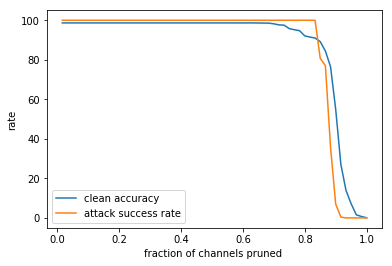

In [29]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asr_rates)
plt.legend(['clean accuracy','attack success rate'])
plt.xlabel("fraction of channels pruned ")
plt.ylabel("rate")


G - repaired network

In [52]:
#new G
class G(keras.Model):
    def __init__(self, B, B_new):
        super(G, self).__init__()
        self.B = B
        self.B_new = B_new

    def predict(self,data):
        predict_B = np.argmax(self.B.predict(data), axis=1)
        predict_B_new = np.argmax(self.B_new.predict(data), axis=1)
    
        predicts = np.zeros(data.shape[0])
        
        for i in range(data.shape[0]):
            if predict_B[i]==predict_B_new[i]:
                predicts[i] = predict_B[i]
                
            else:
                predicts[i] = 1283
                
        return predicts

use  data to evaluate the B' model

In [48]:
#test data
clean_test_data = filePath + 'test.h5'
poisoned_test_data = filePath + 'bd_test.h5'

x_test_data, y_test_data = data_load(clean_test_data)
x_poisoned_test_data, y_poisoned_test_data = data_load(poisoned_test_data)


In [51]:
#model
model_X_2_Name  =  filePath + 'model_X=2.h5'
model_X_4_Name   = filePath +  'model_X=4.h5'
model_X_10_Name   = filePath +  'model_X=10.h5'

model_X_2 = keras.models.load_model(model_X_2_Name)
model_X_4 = keras.models.load_model(model_X_4_Name)
model_X_10 = keras.models.load_model(model_X_10_Name)

In [17]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_poisoned_test_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [35]:
#clean data in B' model
clean_test_2_label_predict = np.argmax(model_X_2.predict(clean_x_test), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_predict, clean_y_test))*100
poisoned_test_2_label_predict = np.argmax(model_X_2.predict(poison_x_test), axis=1)
asr_2 = np.mean(np.equal(poisoned_test_2_label_predict, poison_y_test))*100

print('2% drops model, the clean test data accuracy is :', clean_test_2_accuracy)
print('2% drops model, Attack Success Rate is:', asr_2)


clean_test_10_label_predict = np.argmax(model_X_10.predict(clean_x_test), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_predict, clean_y_test))*100
poisoned_test_10_label_predict = np.argmax(model_X_10.predict(poison_x_test), axis=1)
asr_10 = np.mean(np.equal(poisoned_test_10_label_predict, poison_y_test))*100

print('10% drops model, the clean test data accuracy is :', clean_test_10_accuracy)
print('10% drops model, Attack Success Rate is:', asr_10)



2% drops model, the clean test data accuracy is : 95.75647354291158
2% drops model, Attack Success Rate is: 100.0
10% drops model, the clean test data accuracy is : 84.43751623798389
10% drops model, Attack Success Rate is: 77.015675067117


In [62]:
#test data in B' model
clean_test_2_label_predict = np.argmax(model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_predict, y_test_data))*100
poisoned_test_2_label_predict = np.argmax(model_X_2.predict(x_poisoned_test_data), axis=1)
asr_2 = np.mean(np.equal(poisoned_test_2_label_predict, y_poisoned_test_data))*100

print('2% drops model, the clean test data accuracy is :', clean_test_2_accuracy)
print('2% drops model, Attack Success Rate is:', asr_2)


clean_test_10_label_predict = np.argmax(model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_predict, y_test_data))*100
poisoned_test_10_label_predict = np.argmax(model_X_10.predict(x_poisoned_test_data), axis=1)
asr_10 = np.mean(np.equal(poisoned_test_10_label_predict, y_poisoned_test_data))*100

print('10% drops model, the clean test data accuracy is :', clean_test_10_accuracy)
print('10% drops model, Attack Success Rate is:', asr_10)


2% drops model, the clean test data accuracy is : 95.90023382696803
2% drops model, Attack Success Rate is: 100.0
10% drops model, the clean test data accuracy is : 84.54403741231489
10% drops model, Attack Success Rate is: 77.20966484801247


# use test data to evaluate the repaired network -G

In [53]:
G_model_X_2_temp = G(model, model_X_2)
G_model_X_4_temp = G(model, model_X_4)
G_model_X_10_temp = G(model, model_X_10)

In [54]:
G_model_X_2_temp._is_graph_network = True

combined model

In [55]:

G_model_X_2 = G_model_X_2_temp
G_model_X_4 = G_model_X_4_temp
G_model_X_10 = G_model_X_10_temp


test data in G-model

In [60]:
cl_label_p_2 = G_model_X_2.predict(x_test_data)
clean_accuracy_2 = np.mean(np.equal(cl_label_p_2, y_test_data))*100
print('Clean Classification accuracy-G_model_X_2 :', clean_accuracy_2)
    
bd_label_p_2 = G_model_X_2.predict(x_poisoned_test_data)
asr_2 = np.mean(np.equal(bd_label_p_2, y_poisoned_test_data))*100
print('Attack Success Rate-G_model_X_2:', asr_2)

cl_label_p_4 =G_model_X_4.predict(x_test_data)
clean_accuracy_4 = np.mean(np.equal(cl_label_p_4, y_test_data)) * 100
print('Clean Classification accuracy-G_model_X_4 :', clean_accuracy_4)

bd_label_p_4 = G_model_X_4.predict(x_poisoned_test_data)
asr_4 = np.mean(np.equal(bd_label_p_4, y_poisoned_test_data)) * 100
print('Attack Success Rate-G_model_X_4:', asr_4)


cl_label_p_10 = G_model_X_10.predict(x_test_data)
clean_accuracy_10 = np.mean(np.equal(cl_label_p_10, y_test_data)) * 100
print('Clean Classification accuracy-G_model_X_10 :', clean_accuracy_10)

bd_label_p_10 =G_model_X_10.predict(x_poisoned_test_data)
asr_10 = np.mean(np.equal(bd_label_p_10, y_poisoned_test_data)) * 100
print('Attack Success Rate-G_model_X_10:', asr_10)

Clean Classification accuracy-G_model_X_2 : 95.74434918160561
Attack Success Rate-G_model_X_2: 100.0
Clean Classification accuracy-G_model_X_4 : 92.1278254091972
Attack Success Rate-G_model_X_4: 99.98441153546376
Clean Classification accuracy-G_model_X_10 : 84.3335931410756
Attack Success Rate-G_model_X_10: 77.20966484801247


 Plot the accuracy on clean test data and the attack success rate (on backdoored test 
data) as a function of the fraction of channels pruned.

In [56]:
clean_acc01 = [0] * 60
asrate01= [0] * 60
clean_acc02 = [0] * 60
asrate02= [0] * 60
clean_acc03 = [0] * 60
asrate03= [0] * 60

In [57]:
pool_3_output=G_model_X_2.B_new.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=G_model_X_2.B_new.input,outputs=pool_3_output)
intermediate_prediction=intermediate_model.predict(x_test_data)
res = np.mean(intermediate_prediction,axis=(0,1,2))
seq01 = np.argsort(res)
weight_2 = G_model_X_2.B_new.layers[5].get_weights()[0]
bias_2 = G_model_X_2.B_new.layers[5].get_weights()[1]

In [58]:
pool_3_output=G_model_X_4.B_new.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=G_model_X_4.B_new.input,outputs=pool_3_output)
intermediate_prediction=intermediate_model.predict(x_test_data)
res = np.mean(intermediate_prediction,axis=(0,1,2))
seq02 = np.argsort(res)
weight_4 = G_model_X_4.B_new.layers[5].get_weights()[0]
bias_4 = G_model_X_4.B_new.layers[5].get_weights()[1]

In [59]:
pool_3_output=G_model_X_10.B_new.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=G_model_X_10.B_new.input,outputs=pool_3_output)
intermediate_prediction=intermediate_model.predict(x_test_data)
res = np.mean(intermediate_prediction,axis=(0,1,2))
seq03 = np.argsort(res)
weight_10 = G_model_X_10.B_new.layers[5].get_weights()[0]
bias_10 = G_model_X_10.B_new.layers[5].get_weights()[1]

In [ ]:
for i in range(60):
    channel_index = seq[i]
    
    weight_4[:, :, :, channel_index] = 0
    bias_4[channel_index] = 0
    G_model_X_4.B_new.layers[5].set_weights([weight_4, bias_4])
    
    weight_10[:, :, :, channel_index] = 0
    bias_10[channel_index] = 0
    G_model_X_10.B_new.layers[5].set_weights([weight_10, bias_10])

    
    cl_label_p_4 = G_model_X_4.predict(x_test_data)
    clean_accuracy_4 = np.mean(np.equal(cl_label_p_4, y_test_data)) * 100
    print('Clean Classification accuracy-G_model_X_4 :', clean_accuracy_4)

    bd_label_p_4 =G_model_X_4.predict(x_poisoned_test_data)
    asr_4 = np.mean(np.equal(bd_label_p_4, y_poisoned_test_data)) * 100
    print('Attack Success Rate-G_model_X_4:', asr_4)    
    
    cl_label_p_10 = np.argmax(G_model_X_10.B_new.predict(x_test_data), axis=1)
    clean_accuracy_10 = np.mean(np.equal(cl_label_p_10 , y_test_data)) * 100
    print('Clean Classification accuracy-G_model_X_10 :', clean_accuracy_10)

    bd_label_p_10 = np.argmax(G_model_X_10.B_new.predict(x_poisoned_test_data), axis=1)
    asr_10 = np.mean(np.equal(bd_label_p_10, y_poisoned_test_data)) * 100
    print('Attack Success Rate-G_model_X_10: ', asr_10)
    clean_acc02[i]  = clean_accuracy_4
    asrate02[i] = asr_4
    clean_acc03[i]  = clean_accuracy_10
    asrate03[i] = asr_10
    
    print("#####################################################")

In [71]:
for i in range(60):
    channel_index = seq[i]
    
    weight_2[:, :, :, channel_index] = 0
    bias_2[channel_index] = 0
   
    G_model_X_2.B_new.layers[5].set_weights([weight_2, bias_2])

    cl_label_p_2 =  np.argmax(G_model_X_2.B_new.predict(x_test_data), axis=1)
    clean_accuracy_2 = np.mean(np.equal(cl_label_p_2, y_test_data))*100
    print('Clean Classification accuracy-G_model_X_2 :', clean_accuracy_2)
    
    bd_label_p_2 = np.argmax(G_model_X_2.B_new.predict(x_poisoned_test_data), axis=1)
    asr_2 = np.mean(np.equal(bd_label_p_2, y_poisoned_test_data))*100
    print('Attack Success Rate-G_model_X_2:', asr_2)

    clean_acc01[i] = clean_accuracy_2
    asrate01[i]= asr_2
    
    print("#####################################################")

Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack Success Rate-G_model_X_2: 100.0
#####################################################
Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack Success Rate-G_model_X_2: 100.0
#####################################################
Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack Success Rate-G_model_X_2: 100.0
#####################################################
Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack Success Rate-G_model_X_2: 100.0
#####################################################
Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack Success Rate-G_model_X_2: 100.0
#####################################################
Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack Success Rate-G_model_X_2: 100.0
#####################################################
Clean Classification accuracy-G_model_X_2 : 95.90023382696803
Attack S

Text(0, 0.5, 'rate')

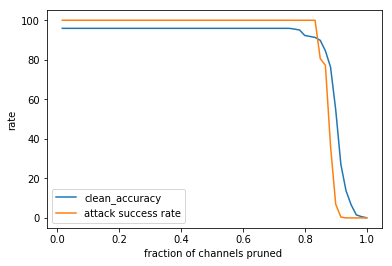

In [72]:
#plot for G_2
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc01)
plt.plot(x_axis,asrate01)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of channels pruned ")
plt.ylabel("rate")

Text(0, 0.5, 'rate')

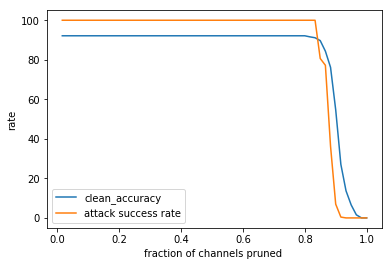

In [73]:
#plot for G_4
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc02)
plt.plot(x_axis,asrate02)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of channels pruned ")
plt.ylabel("rate")

Text(0, 0.5, 'rate')

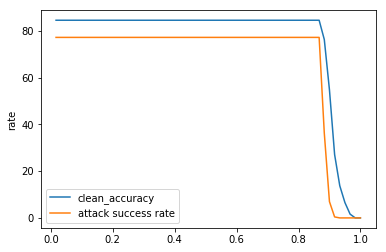

In [74]:
#plot for G_10
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc03)
plt.plot(x_axis,asrate03)
plt.legend(['clean_acc01','asrate01'])
plt.legend(['clean_accuracy','attack success rate'])
plt.ylabel("rate")